# Bitcoin for stock investors

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
from plotly.subplots import make_subplots
sns.set() # Set default Seaborn style

## 1. Importing data 

The data used in this analysis are time series of Bitcoin prices and the stock markets indices S&P500 and ACWI.
These information were downloaded from the following sources:
- S&P: https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview
- Bitcoin: https://fred.stlouisfed.org/series/CBBTCUSD
- ACWI: https://www.nasdaq.com/market-activity/funds-and-etfs/acwi/historical

In [3]:
# Reading Bitcoin data
bitcoin = pd.read_csv('CBBTCUSD_fred.csv', parse_dates=['DATE'], dtype='float', na_values='.')
bitcoin.rename(columns={'DATE':'Date','CBBTCUSD':'BTC_price'}, inplace=True)
bitcoin.head()

,Date,BTC_price
0,2014-12-01,370.0
1,2014-12-02,378.0
2,2014-12-03,378.0
3,2014-12-04,377.1
4,2014-12-05,NaN


In [4]:
# Reading S&P500 data
sp500 = pd.read_excel('SP500.xlsx', parse_dates=['Date'], names=['Date', 'SP500_price'], skiprows=6, usecols=[0,1])
sp500.head()

,Date,SP500_price
0,2012-01-31,1312.41
1,2012-02-01,1324.09
2,2012-02-02,1325.54
3,2012-02-03,1344.90
4,2012-02-06,1344.33


In [5]:
# Reading ACWI data
acwi = pd.read_csv('ACWI_Nasdaq.csv', parse_dates=['Date'])
acwi.rename(columns={'Close/Last':'ACWI_price'}, inplace=True)
acwi.head()

,Date,ACWI_price,Volume,Open,High,Low
0,2022-02-11,99.65,3832908,101.57,102.01,99.400
1,2022-02-10,101.58,3485169,101.84,103.27,101.160
2,2022-02-09,103.07,5696276,102.52,103.07,102.500
3,2022-02-08,101.47,2720580,100.55,101.64,100.340
4,2022-02-07,100.69,3938657,100.93,101.42,100.495


## 2. Data preparation

In [6]:
def df_overview(df):
    """
    The df_overview function summarizes relevant information about a data frame's basic properties

    Args
    df: data frame

    Returns
    - Name, number of rows, number of missing values and number of columns
    - List of columns by data type
    - Number of missing values by column

    """
    
    print('Data:', df.name)
    print('Number of rows:', df.shape[0])
    print('Rows with missing values:', df.isna().any(axis=1).sum())
    print('Number o columns:', df.shape[1])

    for t, n in df.dtypes.value_counts().items():
        col_types = df.select_dtypes(include=t).columns.tolist()
        print(f'Columns of type {t}:', ', '.join(col_types))
    
    col_na = [item for item in df.isna().sum().items()]
    print('Missing values by column:\n', col_na)

In [7]:
# Data frames overview
dfs = [bitcoin, sp500, acwi]
bitcoin.name = 'Bitcoin'
sp500.name = 'S&P500'
acwi.name = 'ACWI'

for df in dfs:
    df_overview(df)
    print()

Data: Bitcoin
Number of rows: 2625
Rows with missing values: 35
Number o columns: 2
Columns of type datetime64[ns]: Date
Columns of type float64: BTC_price
Missing values by column:
 [('Date', 0), ('BTC_price', 35)]

Data: S&P500
Number of rows: 2529
Rows with missing values: 0
Number o columns: 2
Columns of type datetime64[ns]: Date
Columns of type float64: SP500_price
Missing values by column:
 [('Date', 0), ('SP500_price', 0)]

Data: ACWI
Number of rows: 2518
Rows with missing values: 0
Number o columns: 6
Columns of type float64: ACWI_price, Open, High, Low
Columns of type datetime64[ns]: Date
Columns of type int64: Volume
Missing values by column:
 [('Date', 0), ('ACWI_price', 0), ('Volume', 0), ('Open', 0), ('High', 0), ('Low', 0)]



### 2.2 Missing data

As seen above, only Bitcoin data has missing values. A further evaluation of those observations and the treatment applied are shown below

In [8]:
# Selection rows with missing value in Bitcoin data
missing = bitcoin[bitcoin.isna().any(axis=1)]

In [9]:
# Missing information by year and month
missing['Month'] = missing.Date.dt.month
missing['Year'] = missing.Date.dt.year
pd.crosstab(missing['Year'], missing['Month'])

C:\Users\Carlos Alberto\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Carlos Alberto\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Month,1,9,12
Year,,,
2014,0,0,22
2015,12,0,0
2020,0,1,0


In [10]:
# Excluding periods with missing data concentration
bitcoin = bitcoin[bitcoin['Date']>='2015-01-31']

In [11]:
# Inspecting the only missing value left after exclusion
bitcoin[bitcoin.isna().any(axis=1)]

,Date,BTC_price
2104,2020-09-04,NaN


In [12]:
# Imputing Bitcoin value on Sep 04, 2020
# Source: Yahoo Finance website (https://finance.yahoo.com/quote/BTC-USD/history)
bitcoin = bitcoin.fillna(10230.37)

In [13]:
# Checking if all missing data were treated
print(bitcoin.isna().sum())

# Evaluating imputed value
bitcoin[(bitcoin['Date']>='2020-09-01') & (bitcoin['Date']<'2020-09-10')]

Date         0
BTC_price    0
dtype: int64


,Date,BTC_price
2101,2020-09-01,11911.74
2102,2020-09-02,11390.12
2103,2020-09-03,10225.82
2104,2020-09-04,10230.37
2105,2020-09-05,10152.97
2106,2020-09-06,10255.20
2107,2020-09-07,10389.85
2108,2020-09-08,10123.21
2109,2020-09-09,10235.00


In order to equalize the time horizon of the three series, the same exclusion applied to treat missing in the Bitcoin data set is applied to S&P500 and ACWI data. The most recent information is defined as the 31st of January of 2022

In [14]:
bitcoin = bitcoin[bitcoin['Date']<'2022-02-01']
sp500 = sp500[(sp500['Date']>='2015-01-31') & (sp500['Date']<'2022-02-01')]
acwi = acwi[(acwi['Date']>='2015-01-31') & (acwi['Date']<'2022-02-01')]

# Exploratory data analysis

## Daily returns

In [15]:
# Calculating daily returns for each series
sp500['SP500_return'] = sp500['SP500_price'].pct_change()
acwi['ACWI_return'] = acwi['ACWI_price'].pct_change()
bitcoin['BTC_return'] = bitcoin['BTC_price'].pct_change()

# Excluding first observation (NaN for return information)
sp500 = sp500.dropna()
acwi = acwi.dropna()
bitcoin = bitcoin.dropna()

C:\Users\Carlos Alberto\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Carlos Alberto\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
print('AVERAGE RETURNS AND VOLATILITY')
print('\nS&P500\'s average daily returns: %.2f%%' % (round(sp500['SP500_return'].mean(), 4)*100))
print('S&P500\'s daily returns volatility: %.2f%%' % (round(sp500['SP500_return'].std(), 4)*100))

print('\nACWI\'s average daily returns: %.2f%%' % (round(acwi['ACWI_return'].mean(), 4)*100))
print('ACWI\'s daily returns volatility: %.2f%%' % (round(acwi['ACWI_return'].std(), 4)*100))

print('\nBitcoin\'s average daily returns: %.2f%%' % (round(bitcoin['BTC_return'].mean(), 4)*100))
print('Bitcoin\'s daily returns volatility: %.2f%%' % (round(bitcoin['BTC_return'].std(), 4)*100))

AVERAGE RETURNS AND VOLATILITY

S&P500's average daily returns: 0.05%
S&P500's daily returns volatility: 1.13%

ACWI's average daily returns: -0.02%
ACWI's daily returns volatility: 1.11%

Bitcoin's average daily returns: 0.28%
Bitcoin's daily returns volatility: 3.89%


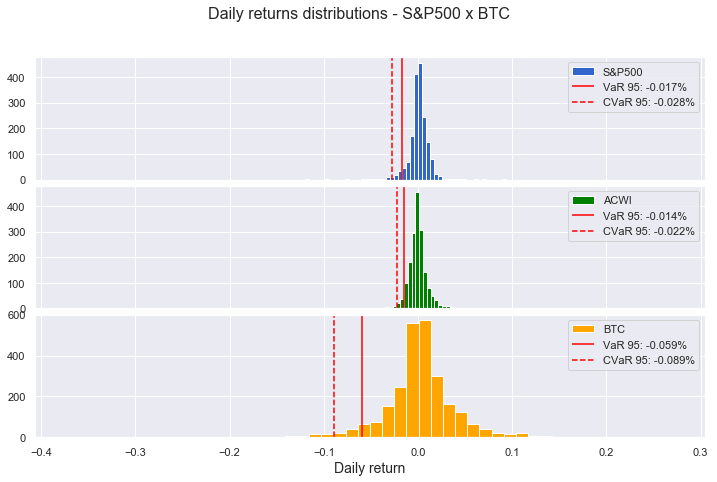

In [17]:
# Ploting the returns distribuition, Var and CVar

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 7), sharex=True)
fig.subplots_adjust(hspace=0.05)


### S&P500 ###

# Calculate historical VaR and CVaR with 95%
var_95 = np.percentile(sp500['SP500_return'], 5)
cvar_95 = sp500.loc[sp500['SP500_return']<var_95, 'SP500_return'].mean()
#print('S&P500:', var_95, cvar_95)

ax1.hist(sp500['SP500_return'], bins=50, density=False, color='#3366CC', label='S&P500')

# Denote the VaR 95 quantile
ax1.vlines([var_95], 0, 1, transform=ax1.get_xaxis_transform(), colors='red', linestyle='solid', label='VaR 95: {0:.3f}%'.format(var_95))
ax1.vlines([cvar_95], 0, 1, transform=ax1.get_xaxis_transform(), colors='red', linestyle='dashed', label='CVaR 95: {0:.3f}%'.format(cvar_95))
ax1.legend()


### ACWI ###

# Calculate historical VaR and CVaR with 95%
var_95 = np.percentile(acwi['ACWI_return'], 5)
cvar_95 = acwi.loc[acwi['ACWI_return']<var_95, 'ACWI_return'].mean()
#print('S&P500:', var_95, cvar_95)

ax2.hist(acwi['ACWI_return'], bins=50, density=False, color='Green', label='ACWI')

# Denote the VaR 95 quantile
ax2.vlines([var_95], 0, 1, transform=ax2.get_xaxis_transform(), colors='red', linestyle='solid', label='VaR 95: {0:.3f}%'.format(var_95))
ax2.vlines([cvar_95], 0, 1, transform=ax2.get_xaxis_transform(), colors='red', linestyle='dashed', label='CVaR 95: {0:.3f}%'.format(cvar_95))
ax2.legend()


### Bitcoin ###

# Calculate historical VaR and CVaR with 95%
var_95 = np.percentile(bitcoin['BTC_return'], 5)
cvar_95 = bitcoin.loc[bitcoin['BTC_return']<var_95, 'BTC_return'].mean()
#print('Bitcoin:', var_95, cvar_95)

ax3.hist(bitcoin['BTC_return'], bins=50, density=False, color='orange', label='BTC')

# Denote the VaR 95 quantile
ax3.vlines([var_95], 0, 1, transform=ax3.get_xaxis_transform(), colors='red', linestyle='solid', label='VaR 95: {0:.3f}%'.format(var_95))
ax3.vlines([cvar_95], 0, 1, transform=ax3.get_xaxis_transform(), colors='red', linestyle='dashed', label='CVaR 95: {0:.3f}%'.format(cvar_95))
ax3.legend()


fig.suptitle("Daily returns distributions - S&P500 x BTC", fontsize=16)
plt.xlabel("Daily return", fontsize=14)
plt.show();

In [46]:
# Plotting line plots and box plots for each return series

fig = make_subplots(rows=3, cols=2, vertical_spacing = 0.02, horizontal_spacing = 0.02,
                    row_titles=['S&P500','ACWI','BTC'], shared_xaxes='columns', shared_yaxes='rows', column_widths=[0.7,0.3])


### S&P500 ###

perc = [round(p*100,2) for p in sp500['SP500_return']]
hov_date = [d for d in sp500['Date'].dt.date]
hover = [str(d) + ': ' + str(p) + '%' for d, p in zip(hov_date, perc)]

# Dispersão (vol)
fig.add_trace(go.Scatter(x=sp500['Date'], y=perc, name='', hoverinfo='text', hovertext=hover, line_color='#3366CC', 
                         showlegend=False, mode='lines'), row=1, col=1)

# Boxplot
fig.add_trace(go.Box(y=perc, name='', showlegend=False, marker_color='#3366CC'), row=1, col=2)



### ACWI ###

perc = [round(p*100,2) for p in acwi['ACWI_return']]
hov_date = [d for d in acwi['Date'].dt.date]
hover = [str(d) + ': ' + str(p) + '%' for d, p in zip(hov_date, perc)]

# Dispersão (vol)
fig.add_trace(go.Scatter(x=acwi['Date'], y=perc, name='', hoverinfo='text', hovertext=hover, line_color='Green', 
                         showlegend=False, mode='lines'), row=2, col=1)

# Boxplot
fig.add_trace(go.Box(y=perc, name='', showlegend=False, marker_color='Green'), row=2, col=2)



### Bitcoin ###

# hover text 
perc = [round(p*100,2) for p in bitcoin['BTC_return']]
hov_date = [d for d in bitcoin['Date'].dt.date]
hover = [str(d) + ': ' + str(p) + '%' for d, p in zip(hov_date, perc)]

# Dispersão (vol)
fig.add_trace(go.Scatter(x=bitcoin['Date'], y=perc, name='',  hoverinfo='text', hovertext=hover, line_color='orange', 
                         showlegend=False, mode='lines'), row=3, col=1)

# Boxplot
fig.add_trace(go.Box(y=perc, name='', showlegend=False, marker_color='orange'), row=3, col=2)


### Layout adjustments ###

fig.update_layout(
    {'title': {'text': 'Daily returns series', 
               'font':{'size':20}, 'x': 0.5, 'y': 0.92}})
fig.update_layout(autosize=False, width=1000, height=800)

fig.show()
fig.write_html("C:\\Users\\Carlos Alberto\\Documents\\Carlos\\Cursos\\Udacity\\daily_returns.html");

In [19]:
# Merging series to create daily price data frame
daily_df = sp500[['Date', 'SP500_price']].merge(acwi[['Date','ACWI_price']], how='left', 
                                                on='Date').merge(bitcoin[['Date','BTC_price']], how='left', on='Date')

# Setting date information as index
daily_df = daily_df.set_index('Date')
daily_df.head()

,SP500_price,ACWI_price,BTC_price
Date,,,
2015-02-03,2050.03,59.39,228.58
2015-02-04,2041.51,59.04,227.11
2015-02-05,2062.52,59.68,216.76
2015-02-06,2055.47,59.18,223.20
2015-02-09,2046.74,58.97,221.10


In [20]:
daily_df.isna().sum()

SP500_price    0
ACWI_price     1
BTC_price      0
dtype: int64

In [21]:
daily_df[daily_df.isna().any(axis=1)]

,SP500_price,ACWI_price,BTC_price
Date,,,
2022-01-31,4515.55,NaN,38430.3


In [22]:
daily_df = daily_df.dropna()

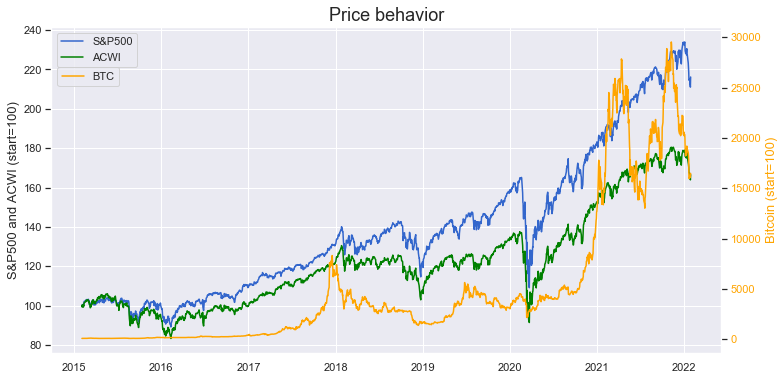

In [44]:
# Creating line plots for evaluating price behaviors

fig, ax1 = plt.subplots(figsize=(12,6))

plt.title('Price behavior', fontsize=18)


### S&P500 ###
price_norm = daily_df['SP500_price'].div(daily_df['SP500_price'].first('D').values[0]).mul(100)
ax1.plot(daily_df.index, price_norm , lw=1.5, color="#3366CC", label='S&P500')
ax1.set_ylabel('S&P500 and ACWI (start=100)', fontsize=13)
ax1.grid(None)

   
### ACWI ###
price_norm = daily_df['ACWI_price'].div(daily_df['ACWI_price'].first('D').values[0]).mul(100)
ax1.plot(daily_df.index, price_norm , lw=1.5, color="Green", label='ACWI')
ax1.grid(None)

    
### Bitcoin ###
price_norm = daily_df['BTC_price'].div(daily_df['BTC_price'].first('D').values[0]).mul(100)
ax2 = ax1.twinx()
ax2.plot(daily_df.index, price_norm, lw=1.5, color="orange", label='BTC')
ax2.set_ylabel('Bitcoin (start=100)', fontsize=13, color="orange")
ax2.grid(None)

for label in ax2.get_yticklabels():
    label.set_color("orange")

ax1.legend() # Legend for primary vertical axis
ax2.legend(loc=(0.009,0.82)) # Legend for secondary vertical axis
plt.show();

In [43]:
# Full period returns
print('Initial values:\n', daily_df.first('D'),'\n')
print('Final values:\n', daily_df.last('D'),'\n')
print('Returns:\n', daily_df.last('D').values[0]/daily_df.first('D').values[0])

Initial values:
             SP500_price  ACWI_price  BTC_price
Date                                          
2015-02-03      2050.03       59.39     228.58 

Final values:
             SP500_price  ACWI_price  BTC_price
Date                                          
2022-01-28      4431.85       98.93    37677.8 

Returns:
 [  2.16184641   1.66576865 164.83419372]


In [24]:
# Merging series to create daily returns data frame
daily_returns = daily_df.pct_change().dropna()
daily_returns.columns = ['SP500', 'ACWI', 'BTC']
daily_returns.head()

,SP500,ACWI,BTC
Date,,,
2015-02-04,-0.004156,-0.005893,-0.006431
2015-02-05,0.010291,0.010840,-0.045573
2015-02-06,-0.003418,-0.008378,0.029710
2015-02-09,-0.004247,-0.003548,-0.009409
2015-02-10,0.010676,0.008479,-0.001040


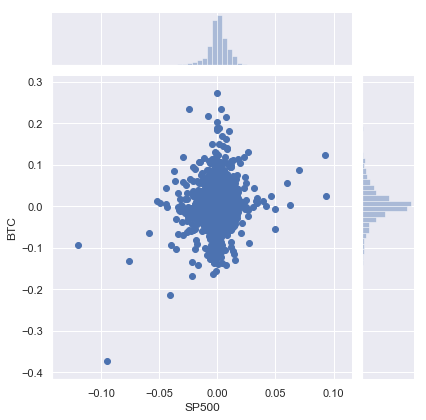

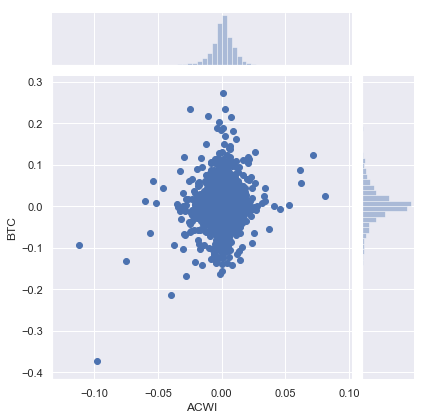

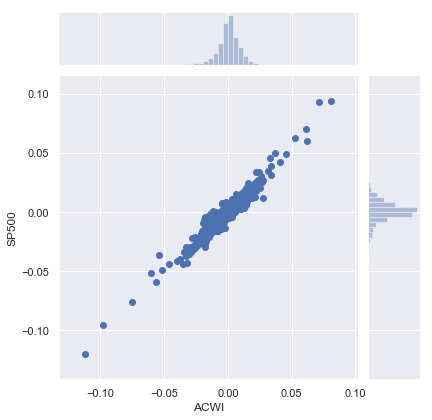

In [25]:
# Joint plots to evaluate relation between return series
sns.jointplot(x='SP500', y='BTC', data=daily_returns)
sns.jointplot(x='ACWI', y='BTC', data=daily_returns)
sns.jointplot(x='ACWI', y='SP500', data=daily_returns);

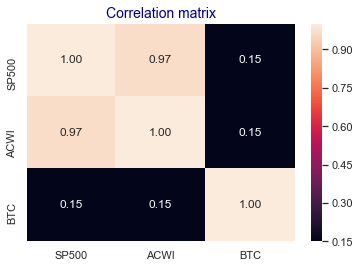

In [26]:
# Correlation matrix
sns.heatmap(daily_returns.corr(), annot=True, fmt=".2f")
plt.title('Correlation matrix', fontsize=14, color='darkBlue');

In [47]:
def roll_corr(s1, s2, window):
    
    """ 
    The roll_corr function generates a series of Pearson's correlation coeficients between two series considering rolling 
    periods
    
    Args: 
    s1 and s2: two times series of returns (s1 and s2), with same length
    window: time horizon in days to be used for rolling correlation calculation
    
    Return: times series with correlation for each rolling period
    """
    
    start = 0
    end = window
    corr_list = []

    ind = s1.index[end-1:]

    while end <= len(s1):
        corr_list.append(np.corrcoef(s1[start:end],s2[start:end])[0,1])
        start += 1
        end = start + window

    return pd.Series(corr_list, index=ind)

In [50]:
# Creating rolling correlation series
corr_sp_btc = roll_corr(daily_returns['SP500'], daily_returns['BTC'], 90)
corr_acwi_btc = roll_corr(daily_returns['ACWI'], daily_returns['BTC'], 90)
corr_series = pd.DataFrame(pd.concat([corr_sp_btc, corr_acwi_btc], axis=1))
corr_series.columns = ['sp_btc','acwi_btc']
#corr_series.head()

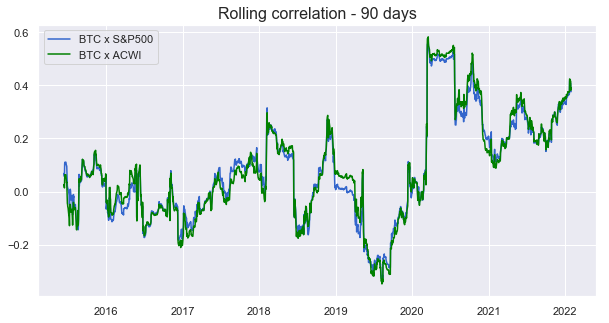

In [51]:
# Plotting correlation series

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(corr_series.index, corr_series['sp_btc'], color='#3366CC', label='BTC x S&P500')
ax1.plot(corr_series.index, corr_series['acwi_btc'], color='Green', label='BTC x ACWI')
plt.legend(loc="upper left")
plt.title("Rolling correlation - 90 days", fontsize=16);

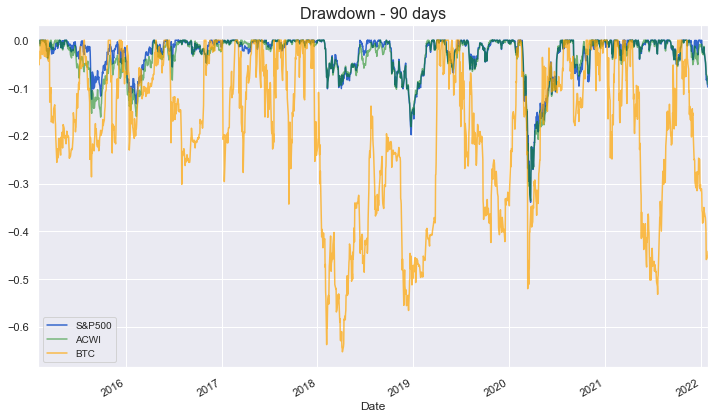

In [30]:
# Comparing rolling price draw downs between series

plt.subplots(figsize=(12,7))

# Calculate the maximum value of returns using rolling().max()
roll_max_sp500 = daily_df['SP500_price'].rolling(min_periods=1,window=90).max()
roll_max_acwi = daily_df['ACWI_price'].rolling(min_periods=1,window=90).max()
roll_max_btc = daily_df['BTC_price'].rolling(min_periods=1,window=90).max()
    
# Calculate daily draw-down from rolling max
daily_drawdown_sp500 = daily_df['SP500_price']/roll_max_sp500 - 1.0
daily_drawdown_acwi = daily_df['ACWI_price']/roll_max_acwi - 1.0
daily_drawdown_btc = daily_df['BTC_price']/roll_max_btc - 1.0
    
# Calculate maximum daily draw-down
#max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=250).min()
# Plot the results
daily_drawdown_sp500.plot(label='S&P500', color="#3366CC")
daily_drawdown_acwi.plot(label='ACWI', color="green", alpha=0.5)
daily_drawdown_btc.plot(label='BTC', color="orange", alpha=0.7)
plt.title('Drawdown - 90 days', fontsize=16)
plt.legend(loc='lower left', fontsize=10)
#max_daily_drawdown.plot()
plt.show();
